#%% [markdown]

 ## データセット概要（Kaggle: Prediction of Mohs Hardness with Machine Learning）

 組成から抽出した原子・電子的特徴量（ファンデルワールス半径、共有結合半径、価電子数など 11 種）を用い、
 鉱物のモース硬度を予測する機械学習モデルを学習する。データは自然鉱物 622 件（結晶系別）と
 検証用の合成単結晶 51 件。CRC Handbook および AMCSD の実験値に基づく。

# %% [markdown]

 ### shape・統計量の確認
 訓練データの形状・列情報・欠損・基本統計量・目的変数（モース硬度）の分布を確認する。

In [ ]:
# %%

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 日本語フォント設定（文字化け防止）
plt.rcParams["font.family"] = ["MS Gothic", "Yu Gothic UI", "Meiryo", "sans-serif"]
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

# --- 定数 ---
DATA_DIR = Path("data")
CRYSTALS_PATH = DATA_DIR / "Artificial_Crystals_Dataset.csv"
MINERAL_PATH = DATA_DIR / "Mineral_Dataset_Supplementary_Info.csv"


def drop_unnamed_index_column(df: pd.DataFrame) -> None:
    """CSV 先頭の Unnamed: 0 列（行番号）を削除する。"""
    if df is None or df.empty:
        return
    first_col = df.columns[0]
    if isinstance(first_col, str) and first_col.startswith("Unnamed"):
        df.drop(columns=[first_col], inplace=True)


def get_target_column(df: pd.DataFrame, default_last: bool = True) -> str:
    """目的変数列（Mohs/Hardness）を取得する。"""
    candidates = [c for c in df.columns if "mohs" in c.lower()]
    if not candidates:
        candidates = [c for c in df.columns if "hardness" in c.lower()]
    if candidates:
        return candidates[0]
    return df.columns[-1] if default_last else ""


def load_data():
    """CSV を読み込み、Unnamed 列を削除して返す。"""
    if not CRYSTALS_PATH.exists():
        raise FileNotFoundError(
            f"{CRYSTALS_PATH} が見つかりません。"
            " data/ に CSV を配置してください。"
        )
    df_artificial = pd.read_csv(CRYSTALS_PATH)
    df_mineral = pd.read_csv(MINERAL_PATH) if MINERAL_PATH.exists() else None
    drop_unnamed_index_column(df_artificial)
    drop_unnamed_index_column(df_mineral)
    return df_artificial, df_mineral

# %% [markdown]

 ### 1. データの読み込み
 使用データ: `Artificial_Crystals_Dataset.csv`（人工結晶）、`Mineral_Dataset_Supplementary_Info.csv`（鉱物・補足情報）。

In [ ]:
# %%

df_artificial, df_mineral = load_data()
print("Artificial_Crystals_Dataset 読み込み完了.")
if df_mineral is not None:
    print("Mineral_Dataset_Supplementary_Info 読み込み完了.")
else:
    print("Mineral_Dataset_Supplementary_Info は存在しません（省略可）. ")

Artificial_Crystals_Dataset 読み込み完了.
Mineral_Dataset_Supplementary_Info 読み込み完了.


# %% [markdown]

 ### 2. Shape（行数・列数）

In [ ]:
# %%

print("【Artificial_Crystals_Dataset】")
print("df_artificial.shape:", df_artificial.shape)
print("行数 len(df_artificial):", len(df_artificial))
print("列数 len(df_artificial.columns):", len(df_artificial.columns))
if df_mineral is not None:
    print("\n【Mineral_Dataset_Supplementary_Info】")
    print("df_mineral.shape:", df_mineral.shape)

【Artificial_Crystals_Dataset】
df_artificial.shape: (52, 14)
行数 len(df_artificial): 52
列数 len(df_artificial.columns): 14

【Mineral_Dataset_Supplementary_Info】
df_mineral.shape: (622, 12)


# %% [markdown]

 ### 3. 列情報（列名・型）

In [ ]:
# %%

print("列名 df_artificial.columns.tolist():")
print(df_artificial.columns.tolist())
print("\ndf_artificial.dtypes:")
print(df_artificial.dtypes)

列名 df_artificial.columns.tolist():
['Formula', 'Crystal structure', 'Hardness (Mohs)', 'allelectrons_Total', 'density_Total', 'allelectrons_Average', 'val_e_Average', 'atomicweight_Average', 'ionenergy_Average', 'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average', 'zaratio_Average', 'density_Average']

df_artificial.dtypes:
Formula                      str
Crystal structure            str
Hardness (Mohs)          float64
allelectrons_Total       float64
density_Total            float64
allelectrons_Average     float64
val_e_Average            float64
atomicweight_Average     float64
ionenergy_Average        float64
el_neg_chi_Average       float64
R_vdw_element_Average    float64
R_cov_element_Average    float64
zaratio_Average          float64
density_Average          float64
dtype: object


# %% [markdown]

 ### 3.1. 列名の意味と日本語訳の対応

 #### 基本情報列

 | 列名 | 日本語訳 | 意味 |
 |------|----------|------|
 | `Formula` | 化学式 | 材料の化学組成式（例: MnTeMoO6, MgH2） |
 | `Crystal structure` | 結晶構造 | 結晶系（tetragonal: 正方晶、monoclinic: 単斜晶、cubic: 立方晶 など） |
 | `Hardness (Mohs)` / `Hardness` | モース硬度 | 材料の硬さを表す値（1〜10のスケール） |

 #### 原子・電子的特徴量（Total = 合計値、Average = 平均値）

 | 列名 | 日本語訳 | 意味 |
 |------|----------|------|
 | `allelectrons_Total` | 全電子数（合計） | 組成中の全原子の電子数の合計 |
 | `allelectrons_Average` | 全電子数（平均） | 組成中の原子1個あたりの平均電子数 |
 | `val_e_Average` | 価電子数（平均） | 原子1個あたりの平均価電子数（最外殻電子数） |
 | `atomicweight_Average` | 原子量（平均） | 原子1個あたりの平均原子量 |
 | `ionenergy_Average` | イオン化エネルギー（平均） | 中性原子から電子を1個取り除くのに必要なエネルギー（平均） |
 | `el_neg_chi_Average` | 電気陰性度（平均） | ポーリング電気陰性度の平均値（電子を引き寄せる強さ） |
 | `R_vdw_element_Average` | ファンデルワールス半径（平均） | 原子間の弱い相互作用を考慮した半径の平均 |
 | `R_cov_element_Average` | 共有結合半径（平均） | 共有結合における原子半径の平均 |
 | `zaratio_Average` | Z/A比（平均） | 原子番号（Z）と原子量（A）の比の平均 |
 | `density_Total` | 密度（合計） | 組成全体の密度関連値の合計 |
 | `density_Average` | 密度（平均） | 原子1個あたりの平均密度関連値 |

 **注意**: `Total` は組成全体の合計値、`Average` は原子1個あたりの平均値を表します。
 これらは組成から計算された原子・電子的特徴量で、モース硬度の予測に使用されます。

# %% [markdown]

 ### 4. 欠損値

In [ ]:
# %%

missing = df_artificial.isna().sum()
print("列ごとの欠損数 (df_artificial.isna().sum()):")
print(missing[missing > 0] if missing.any() else "欠損なし")
if not missing.any():
    print("(全列 0 件)")

列ごとの欠損数 (df_artificial.isna().sum()):
Crystal structure    1
dtype: int64


# %% [markdown]

 ### 5. 基本統計量（describe）

In [ ]:
# %%

print("df_artificial.describe():")
print(df_artificial.describe().to_string())

df_artificial.describe():
       Hardness (Mohs)  allelectrons_Total  density_Total  allelectrons_Average  val_e_Average  atomicweight_Average  ionenergy_Average  el_neg_chi_Average  R_vdw_element_Average  R_cov_element_Average  zaratio_Average  density_Average
count        52.000000           52.000000      52.000000             52.000000      52.000000             52.000000          52.000000           52.000000              52.000000              52.000000        52.000000        52.000000
mean          5.448462          241.090558      26.747887             15.253121       4.379545             33.908160          10.660907            2.574434               1.669348               0.891354         0.472756         1.734518
std           1.523433          293.470156      33.710283              8.419359       1.117464             20.672876           2.353549            0.577003               0.357682               0.231931         0.111901         1.111887
min           2.500000        

# %% [markdown]

 ### 6. 目的変数（Mohs hardness）の確認
 Artificial_Crystals は "Hardness (Mohs)"、Mineral は "Hardness" を目的変数として使用します。

In [ ]:
# %%

target_col = get_target_column(df_artificial)
print("目的変数として使用する列:", repr(target_col))

目的変数として使用する列: 'Hardness (Mohs)'


In [ ]:
# %%

print("目的変数 describe():")
print(df_artificial[target_col].describe())
print("\n目的変数 value_counts() (件数順):")
print(df_artificial[target_col].value_counts().sort_index())

目的変数 describe():
count    52.000000
mean      5.448462
std       1.523433
min       2.500000
25%       4.500000
50%       5.500000
75%       6.500000
max       9.000000
Name: Hardness (Mohs), dtype: float64

目的変数 value_counts() (件数順):
Hardness (Mohs)
2.50    2
3.00    4
4.00    5
4.50    6
4.70    1
5.00    5
5.40    1
5.50    4
5.75    1
6.00    6
6.35    1
6.42    1
6.50    7
6.60    1
7.00    2
8.00    2
8.10    1
8.50    1
9.00    1
Name: count, dtype: int64


findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not

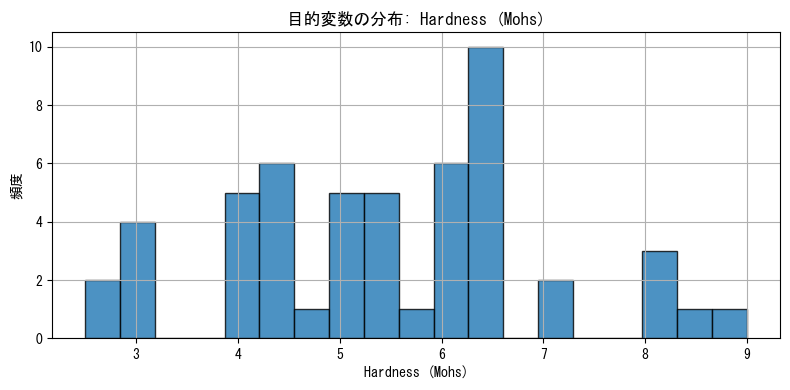

In [ ]:
# %%

fig, ax = plt.subplots(figsize=(8, 4))
df_artificial[target_col].hist(bins=min(30, df_artificial[target_col].nunique()), ax=ax, edgecolor="black", alpha=0.8)
ax.set_xlabel(target_col)
ax.set_ylabel("頻度")
ax.set_title(f"目的変数の分布: {target_col}")
plt.tight_layout()
plt.show()

In [ ]:
#%%

print(df_artificial.head())

          Formula Crystal structure  Hardness (Mohs)  allelectrons_Total  \
0        MnTeMoO6        tetragonal              4.5               167.0   
1            MgH2        tetragonal              4.0                14.0   
2  CO(NH2)2C4H6O5        monoclinic              2.5               102.0   
3           GaPO4          trigonal              5.5                78.0   
4          Ga3PO7          trigonal              6.5               164.0   

   density_Total  allelectrons_Average  val_e_Average  atomicweight_Average  \
0      23.907992             18.555556       5.000000             41.609136   
1       1.740168              4.666667       1.333333              8.773227   
2       8.511159              4.434783       3.304348              8.440584   
3       8.109328             13.000000       5.333333             27.448814   
4      19.921324             14.909091       5.090909             32.012361   

   ionenergy_Average  el_neg_chi_Average  R_vdw_element_Average  \
0

In [ ]:
#%%

df_mineral.head() if df_mineral is not None else None

,Hardness,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,2.3,110.0,23.000000,36.666667,2.666667,82.598467,8.504133,2.146667,2.006667,1.253333,0.456803,7.666667
1,5.5,406.0,30.472136,9.902439,4.682927,19.813180,11.456151,2.700244,1.676829,0.868293,0.522909,0.743223
2,5.5,406.0,30.472464,10.410256,4.923077,20.931371,11.541405,2.753590,1.703846,0.894359,0.497498,0.781345
3,5.5,476.0,61.142136,11.609756,4.682927,23.659644,11.487395,2.763659,1.714634,0.848780,0.519474,1.491272
4,5.5,476.0,61.142464,12.205128,4.923077,24.975089,11.574251,2.820256,1.743590,0.873846,0.493887,1.567755


In [ ]:
# %%

numeric_cols = df_artificial.select_dtypes(include="number").columns

# 列名と日本語訳の対応（3.1の表に基づく）
COL_LABELS_JA = {
    "allelectrons_Total": "全電子数（合計）",
    "allelectrons_Average": "全電子数（平均）",
    "val_e_Average": "価電子数（平均）",
    "atomicweight_Average": "原子量（平均）",
    "ionenergy_Average": "イオン化エネルギー（平均）",
    "el_neg_chi_Average": "電気陰性度（平均）",
    "R_vdw_element_Average": "ファンデルワールス半径（平均）",
    "R_cov_element_Average": "共有結合半径（平均）",
    "zaratio_Average": "Z/A比（平均）",
    "density_Total": "密度（合計）",
    "density_Average": "密度（平均）",
    "Hardness (Mohs)": "モース硬度",
    "Hardness": "モース硬度",
}

findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not found.
findfont: Font family 'Yu Gothic UI' not

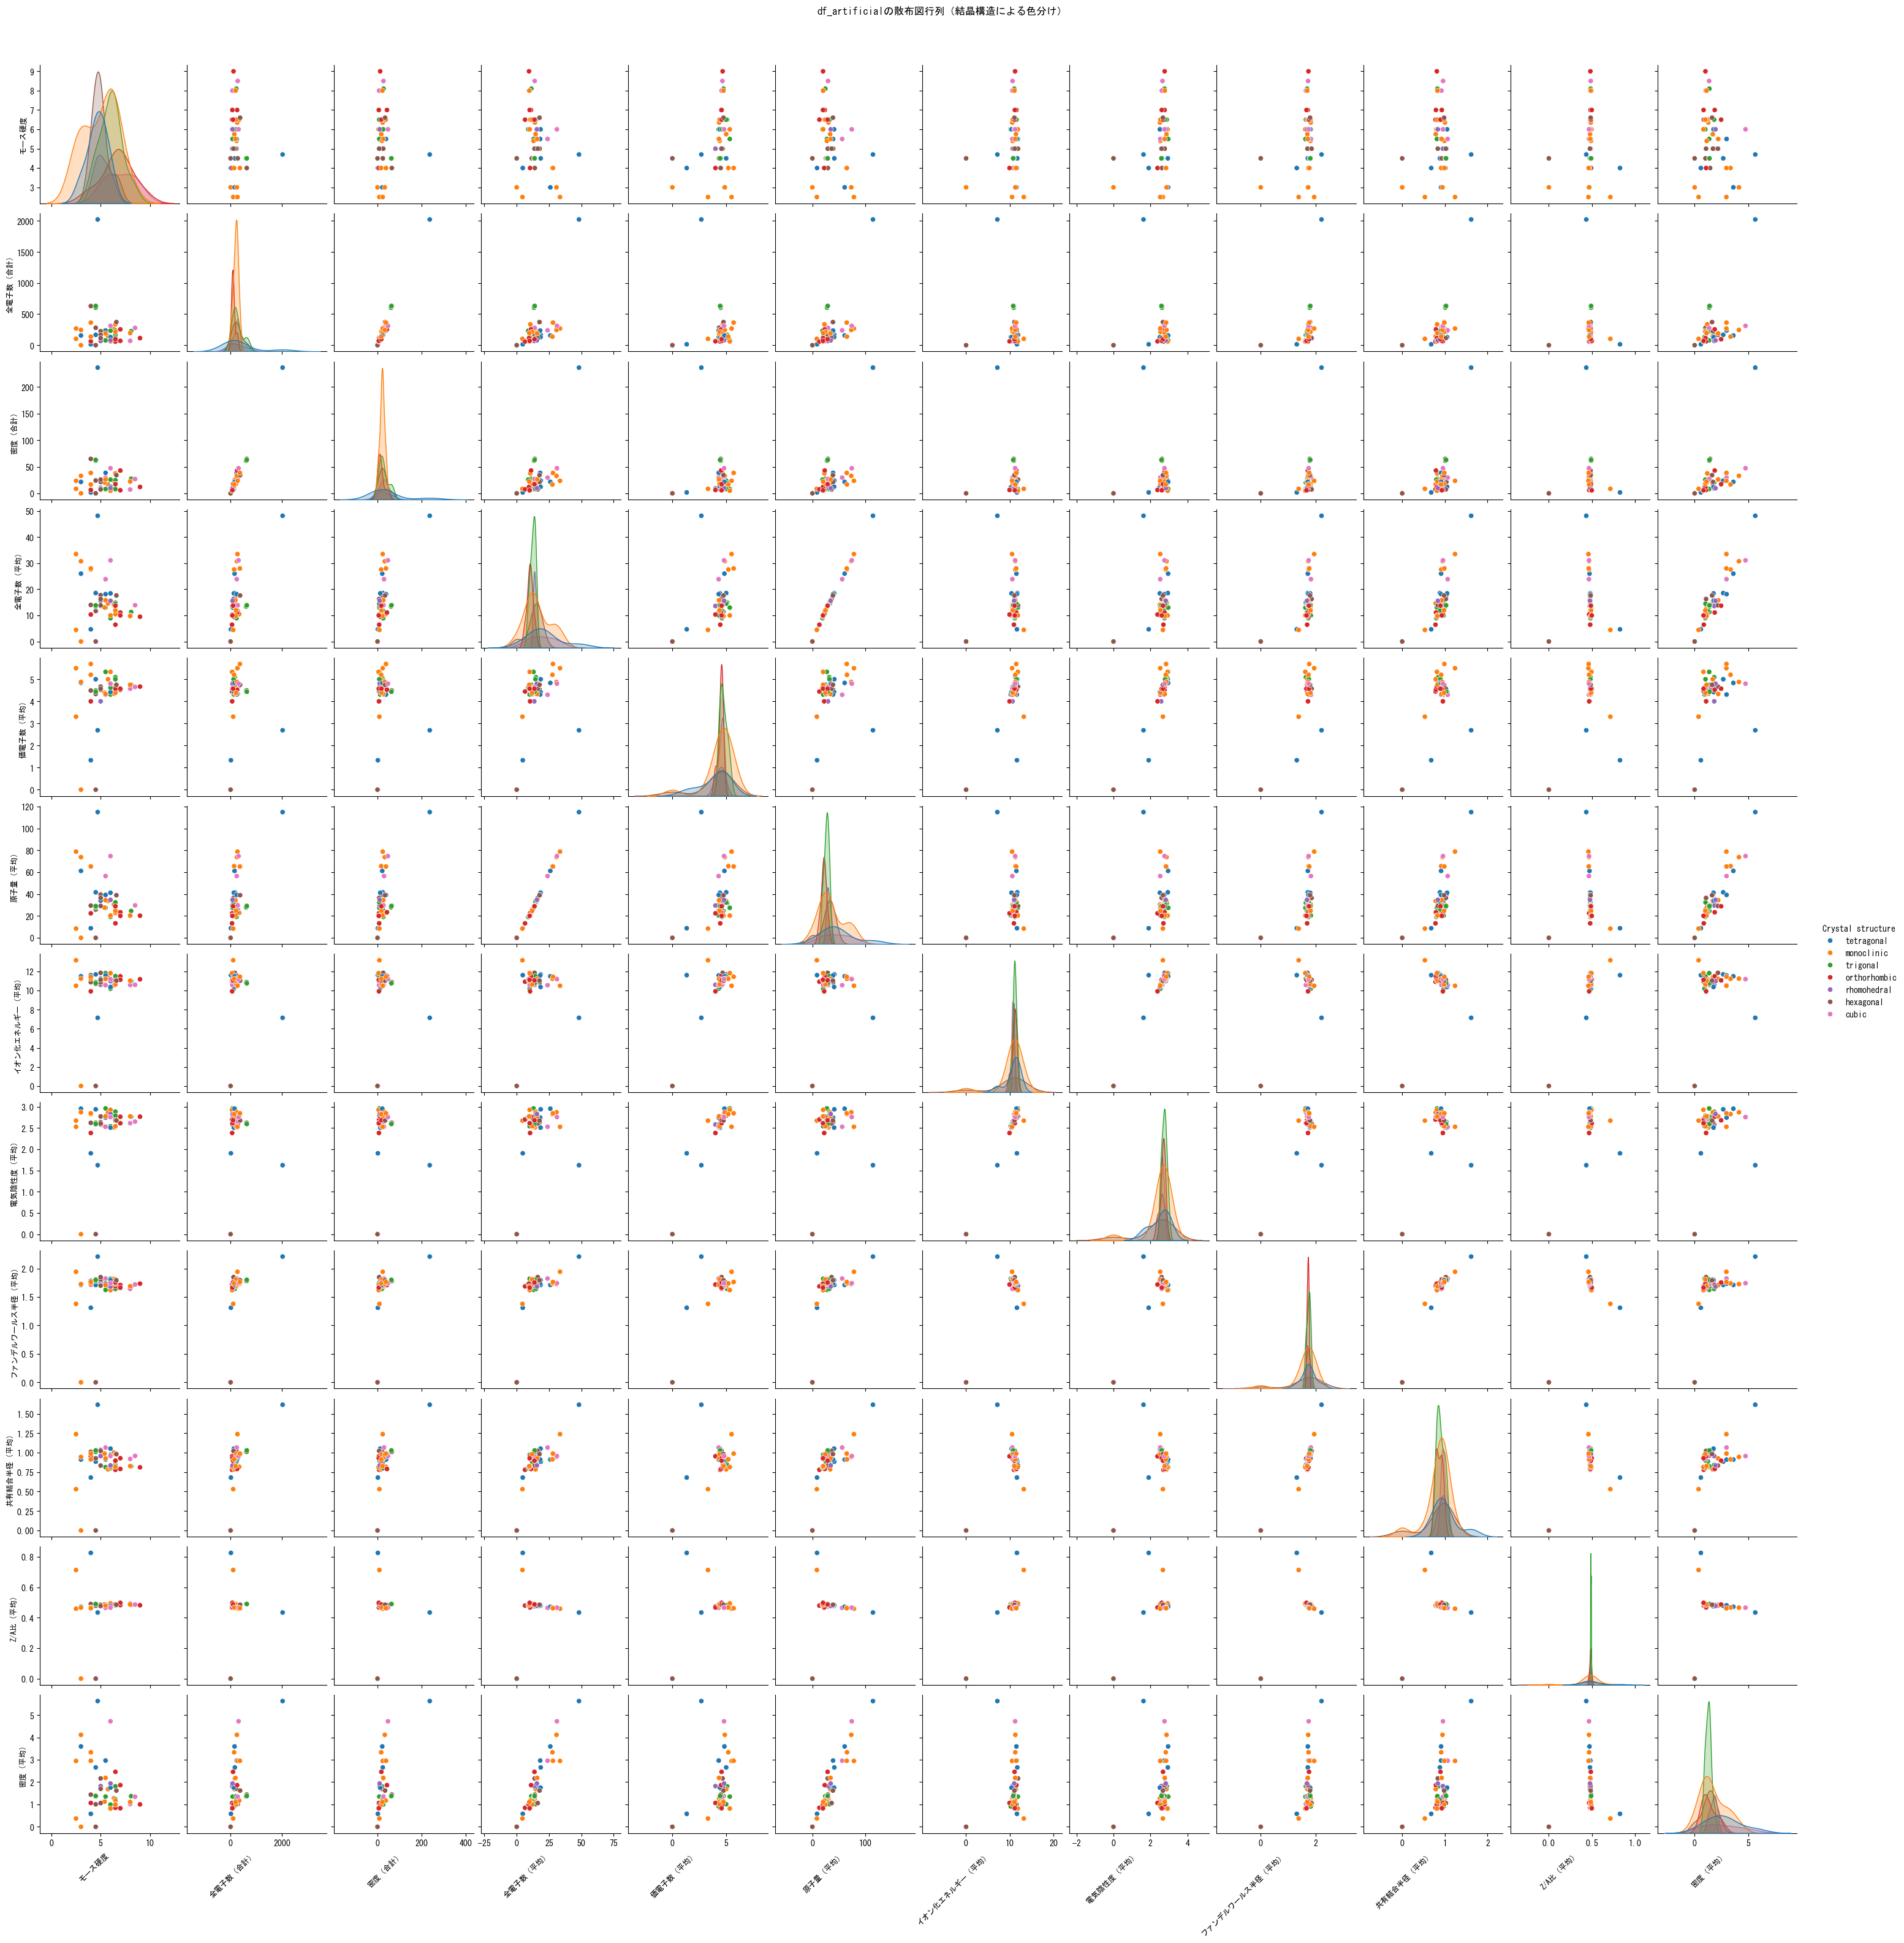

In [ ]:
# %%

# df_artificialの散布図行列をCrystal structureで色分け
if "Crystal structure" in df_artificial.columns:
    if len(numeric_cols) > 1:
        g = sns.pairplot(df_artificial, vars=numeric_cols, hue="Crystal structure", palette="tab10")
        n = len(numeric_cols)
        for i in range(n):
            for j in range(n):
                ax = g.axes[i, j]
                xl = ax.get_xlabel()
                yl = ax.get_ylabel()
                ax.set_xlabel(COL_LABELS_JA.get(xl, xl), fontsize=9, rotation=45, ha="right")
                ax.set_ylabel(COL_LABELS_JA.get(yl, yl), fontsize=9)
        plt.suptitle("df_artificialの散布図行列（結晶構造による色分け）", y=1.02)
        plt.show()
    else:
        print("df_artificial: 数値カラムが1つ以下のため、散布図行列は作成できません。")
else:
    print("df_artificialに 'crystal structure' 列がありません。")

#%% [markdown]

 ### 7. LightGBM による 5 分割交差検証
 df_mineral のモース硬度を目的変数として予測モデルを学習・評価する。

In [ ]:
# %%

if df_mineral is None:
    raise FileNotFoundError("Mineral_Dataset_Supplementary_Info.csv が必要です。LightGBM 解析をスキップする場合はこのセルを省略してください。")

target_col = get_target_column(df_mineral)
print(f"df_mineral 目的変数として使用する列: {target_col}")

# 数値特徴量を説明変数とする
features = df_mineral.select_dtypes(include="number").drop(columns=[target_col], errors="ignore").columns.tolist()
if not features:
    raise ValueError("数値特徴量が見つかりません。")

X = df_mineral[features]
y = df_mineral[target_col]

# 欠損値補完（平均値で埋める）
X = X.fillna(X.mean())
y = y.fillna(y.mean())

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmses = []
fold = 1

for train_idx, test_idx in kf.split(X):
    print(f"\n--- Fold {fold} ---")
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # LightGBM用データセット
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_test, y_test, reference=lgb_train)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'seed': 42,
    }

    model = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=[lgb_train, lgb_valid],
    callbacks=[
        lgb.early_stopping(stopping_rounds=10, verbose=False),
        lgb.log_evaluation(period=0),  # 学習ログを出さない
    ],
)

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    rmse = float(root_mean_squared_error(y_test, y_pred))
    rmses.append(rmse)
    print(f"Fold {fold} RMSE: {rmse:.4f}")

    # 最初のfoldだけ特徴量重要度を表示
    if fold == 1:
        importances = model.feature_importance(importance_type='gain')
        feat_imp = sorted(zip(features, importances), key=lambda t: t[1], reverse=True)
        print("特徴量重要度:")
        for f, imp in feat_imp:
            print(f"{f}: {imp:.2f}")

    fold += 1

print(f"\n5分割交差検証 RMSE (平均±標準偏差): {np.mean(rmses):.4f} ± {np.std(rmses):.4f}")

df_mineral 目的変数として使用する列: Hardness

--- Fold 1 ---
Fold 1 RMSE: 0.8930
特徴量重要度:
R_cov_element_Average: 1193.78
density_Average: 989.57
zaratio_Average: 924.72
val_e_Average: 794.16
allelectrons_Average: 774.27
R_vdw_element_Average: 518.55
atomicweight_Average: 402.02
density_Total: 400.28
allelectrons_Total: 378.13
ionenergy_Average: 375.91
el_neg_chi_Average: 354.01

--- Fold 2 ---
Fold 2 RMSE: 0.9955

--- Fold 3 ---
Fold 3 RMSE: 1.1324

--- Fold 4 ---
Fold 4 RMSE: 1.1197

--- Fold 5 ---
Fold 5 RMSE: 0.9549

5分割交差検証 RMSE (平均±標準偏差): 1.0191 ± 0.0933
